Through the next exercises, we will learn how to build a data generating process (DGP) through progressively complex examples.

In this exercise, we will simulate a very **simple DGP (Data Generating Process)**. Suppose that you are about to take a driving test tomorrow. Based on your own practice and based on data you have gathered, you know that the probability of you passing the test is 90% when it's sunny and only 30% when it's raining. Your local weather station forecasts that there's a 40% chance of rain tomorrow. Based on this information, you want to know what is the probability of you passing the driving test tomorrow.

In [4]:
import numpy as np

In [2]:
sims = 1000
outcomes = []
p_rain = 0.4
p_pass = {'sun':0.9, 'rain':0.3}

def test_outcome(p_rain):  
    # Simulate whether it will rain or not
    weather = np.random.choice(['rain', 'sun'], p=[p_rain,1-p_rain])
    # Simulate and return whether you will pass or fail
    test_result = np.random.choice(['pass', 'fail'], p=[p_pass[weather],1-p_pass[weather]])
    return test_result

In [3]:
for _ in range(sims):
    outcomes.append(test_outcome(p_rain))

# Calculate fraction of outcomes where you pass
pass_outcomes_frac = (np.array(outcomes)=='pass').mean()
print(f'Probability of Passing the driving test = {round(pass_outcomes_frac,3)}')

Probability of Passing the driving test = 0.647


A taste of how you can model a DGP at different levels of complexity.

Consider national elections in a country with two political parties - Red and Blue. This country has 50 states and the party that wins the most states wins the elections. You have the probability p of Red winning in each individual state and want to know the probability of Red winning nationally.

Let's model the DGP to understand the distribution. Suppose the election outcome in each state follows a binomial distribution with probability p such that 0 indicates a loss for Red and 1 indicates a win. We then simulate a number of election outcomes. Finally, we can ask rich questions like **what is the probability of Red winning less than 45% of the states?**

In [4]:
results= np.random.binomial(50, 0.5, 10000)

In [5]:
(results<0.45*50).mean()

0.2379

In [6]:
outcomes, sims, probs = [], 1000, 0.5

for _ in range(sims):
    # Simulate elections in the 50 states
    election = np.random.binomial(p=probs, n=1,size=50)
    # Get average of Red wins and add to `outcomes`
    outcomes.append(election.mean())

# Calculate probability of Red winning in less than 45% of the states
prob_red_wins = sum([(x < 0.45) for x in outcomes])/len(outcomes)
print("Probability of Red winning in less than 45% of the states = {}".format(prob_red_wins))

Probability of Red winning in less than 45% of the states = 0.241


Let's model how activity levels impact weight loss using modern fitness trackers. On days when you go to the gym, you average around 15k steps, and around 5k steps otherwise. You go to the gym 40% of the time. Let's model the step counts in a day as a Poisson random variable with a mean λ dependent on whether or not you go to the gym.

For simplicity, let’s say you have an 80% chance of losing 1lb and a 20% chance of gaining 1lb when you get more than 10k steps. The probabilities are reversed when you get less than 8k steps. Otherwise, there's an even chance of gaining or losing 1lb. Given all this information, find the probability of losing weight in a month.

In [7]:
sims=10000
days=31
outcomes=[]
# Simulate steps & choose prob 

for _ in range(sims):
    w = []
    for i in range(days):
        lam = np.random.choice([5000, 15000], p=[0.6, 0.4], size=1)
        steps = np.random.poisson(lam)

        if steps > 10000: 
            prob = [0.2,0.8]
        elif steps < 8000: 
            prob = [0.8,0.2]
        else:
            prob = [0.5, 0.5]
        w.append(np.random.choice([1, -1], p=prob))
    outcomes.append(sum(w))

In [8]:
# Calculate fraction of outcomes where there was a weight loss
weight_loss_outcomes_frac = (np.array(outcomes)<0).mean()
print("Probability of Weight Loss = {}".format(weight_loss_outcomes_frac))

Probability of Weight Loss = 0.2481


## Ecommerce

We will now model the DGP of an eCommerce ad flow starting with sign-ups.

On any day, we get many ad impressions, which can be modeled as Poisson random variables (RV). You are told that λ is normally distributed with a mean of 100k visitors and standard deviation 2000.

During the signup journey, the customer sees an ad, decides whether or not to click, and then whether or not to signup. Thus both clicks and signups are binary, modeled using binomial RVs. What about probability p of success? Our current low-cost option gives us a click-through rate of 1% and a sign-up rate of 20%. A higher cost option could increase the clickthrough and signup rate by **up to 20%, but we are unsure of the level of improvement**, so we model it as a uniform RV.

In [9]:
# Initialize click-through rate and signup rate dictionaries
ctlow=0.01
sulow=0.2
ct_rate = {'low':ctlow, 'high':np.random.uniform(low=ctlow, high=1.2*ctlow)}
su_rate = {'low':sulow, 'high':np.random.uniform(low=sulow, high=1.2*sulow)}

In [10]:
def get_signups(cost, ct_rate, su_rate, sims):
    lam = np.random.normal(loc=100000, scale=2000, size=sims)
    # Simulate impressions(poisson), clicks(binomial) and signups(binomial)
    impressions = np.random.poisson(lam=lam)
    clicks = np.random.binomial(impressions, p=ct_rate[cost])
    signups = np.random.binomial(clicks, p=su_rate[cost])
    return signups

In [11]:
print("Simulated Signups = {}".format(get_signups('high', ct_rate, su_rate, 10)))

Simulated Signups = [270 232 246 228 244 269 275 215 230 255]


In [12]:
#other way of doing it
def get_signups2(cost, ct_rate, su_rate, sims):
    signups_list=[]
    lam = np.random.normal(loc=100000, scale=2000, size=sims)
    # Simulate impressions(poisson), clicks(binomial) and signups(binomial)
    for x in lam:
        impressions = np.random.poisson(lam= x)
        clicks = np.random.binomial(impressions, p=ct_rate[cost])
        signups = np.random.binomial(clicks, p=su_rate[cost])
        signups_list.append(signups)
        
    return signups_list

In [13]:
print("Simulated Signups = {}".format(get_signups2('high', ct_rate, su_rate, 10)))

Simulated Signups = [255, 267, 212, 228, 270, 249, 228, 268, 253, 230]


After signups, let's model the revenue generation process. Once the customer has signed up, they decide whether or not to purchase - a natural candidate for a binomial RV. Let's assume that 10% of signups result in a purchase.

Although customers can make many purchases, let's assume one purchase. The purchase value could be modeled by any continuous Random Variable, but one nice candidate is the exponential RV. Suppose we know that purchase value per customer has averaged around $1000. 

In [14]:
def get_revenue(signups):
    rev = []
    np.random.seed(123)
    for s in signups:
        # Model purchases as binomial, purchase_values as exponential
        purchases = np.random.binomial(s, p=0.1)
        purchase_values = np.random.exponential(scale=1000, size=purchases)
        
        # Append to revenue the sum of all purchase values.
        rev.append(purchase_values.sum())
    return rev

print(f"Simulated Revenue = ${round(get_revenue(get_signups('low', ct_rate, su_rate, 1))[0],3)}")

Simulated Revenue = $22014.194


Probability of losing money
In this exercise, we will use the DGP model to estimate probability.

As seen earlier, this company has the option of spending extra money, let's say **3000**, to redesign the ad. This could potentially get them higher clickthrough and signup rates, but this is not guaranteed. We would like to know whether or not to spend this extra $3000 by calculating the probability of losing money. In other words, the probability that the revenue from the high-cost option minus the revenue from the low-cost option is lesser than the cost.

Once we have simulated revenue outcomes, we can ask a rich set of questions that might not have been accessible using traditional analytical methods.

This simple yet powerful framework forms the basis of Bayesian methods for getting probabilities.

In [15]:
# Initialize cost_diff
sims, cost_diff = 10000, 3000

# Get revenue when the cost is 'low' and when the cost is 'high'
rev_low = get_revenue(get_signups('low', ct_rate, su_rate, sims))
rev_high = get_revenue(get_signups('high', ct_rate, su_rate, sims))

In [16]:
# calculate fraction of times rev_high - rev_low is less than cost_diff
frac = (np.array(rev_high)-np.array(rev_low)<cost_diff).mean()
print("Probability of losing money = {}".format(frac))

Probability of losing money = 0.4312


## Review on Resampling

In this exercise, we will review the difference between sampling with and without replacement. We will calculate the probability of an event using simulation, but vary our sampling method to see how it impacts probability.

Consider a bowl filled with colored candies - three blue, two green, and five yellow. Draw three candies, one at a time, with replacement and without replacement. You want to calculate the probability that all three candies are yellow.

In [16]:
bowl=list('b'*3+'g'*2+'y'*5)
sims=10000
success_rep= 0
success_norep=0

for _ in range(sims):
    sample_rep = np.random.choice(bowl, size=3, replace=True)
    sample_no_rep = np.random.choice(bowl, size=3, replace=False)
    if (['y','y','y'] == sample_rep).all():
        success_rep +=1
    if (['y','y','y'] == sample_no_rep).all():
        success_norep +=1

In [19]:
# Calculate probabilities
prob_with_replacement = success_rep/sims
prob_without_replacement = success_norep/sims
print("Probability with replacement = {}, without replacement = {}".format(prob_with_replacement, prob_without_replacement))

Probability with replacement = 0.131, without replacement = 0.0849


### With Bootstrap:

Suppose you own a factory that produces wrenches. You want to be able to characterize the average length of the wrenches and ensure that they meet some specifications. Your factory produces thousands of wrenches every day, but it's infeasible to measure the length of each wrench. However, you have access to a representative sample of 100 wrenches. Let's use bootstrapping to get the 95% confidence interval (CI) for the average lengths

In [22]:
wrench_lengths= np.array([ 8.9143694 , 10.99734545, 10.2829785 ,  8.49370529,  9.42139975,
       11.65143654,  7.57332076,  9.57108737, 11.26593626,  9.1332596 ,
        9.32111385,  9.90529103, 11.49138963,  9.361098  ,  9.55601804,
        9.56564872, 12.20593008, 12.18678609, 11.0040539 , 10.3861864 ,
       10.73736858, 11.49073203,  9.06416613, 11.17582904,  8.74611933,
        9.3622485 , 10.9071052 ,  8.5713193 ,  9.85993128,  9.1382451 ,
        9.74438063,  7.20141089,  8.2284669 ,  9.30012277, 10.92746243,
        9.82636432, 10.00284592, 10.68822271,  9.12046366, 10.28362732,
        9.19463348,  8.27233051,  9.60910021, 10.57380586, 10.33858905,
        9.98816951, 12.39236527, 10.41291216, 10.97873601, 12.23814334,
        8.70591468,  8.96121179, 11.74371223,  9.20193726, 10.02968323,
       11.06931597, 10.89070639, 11.75488618, 11.49564414, 11.06939267,
        9.22729129, 10.79486267, 10.31427199,  8.67373454, 11.41729905,
       10.80723653, 10.04549008,  9.76690794,  8.80169886, 10.19952407,
       10.46843912,  9.16884502, 11.16220405,  8.90279695,  7.87689965,
       11.03972709,  9.59663396,  9.87397041,  9.16248328,  8.39403724,
       11.25523737,  9.31113102, 11.66095249, 10.80730819,  9.68524185,
        8.9140976 ,  9.26753801,  8.78747687, 12.08711336, 10.16444123,
       11.15020554,  8.73264795, 10.18103513, 11.17786194,  9.66498924,
       11.03111446,  8.91543209,  8.63652846, 10.37940061,  9.62082357])

In [23]:
# Draw some random sample with replacement and append mean to mean_lengths.
mean_lengths, sims = [], 1000
for i in range(sims):
    temp_sample = np.random.choice(wrench_lengths, replace=True, size=len(wrench_lengths))
    sample_mean = np.mean(temp_sample)
    mean_lengths.append(sample_mean)
    
# Calculate bootstrapped mean and 95% confidence interval.
boot_mean = np.mean(mean_lengths)
boot_95_ci = np.percentile(mean_lengths, [2.5, 97.5])
print("Bootstrapped Mean Length = {}, 95% CI = {}".format(boot_mean, boot_95_ci))

Bootstrapped Mean Length = 10.0372372016, 95% CI = [ 9.82712783 10.26522322]


Suppose you are studying the health of students. You are given the height and weight of 1000 students and are interested in the median height as well as the correlation between height and weight and the associated 95% CI for these quantities. Let's use bootstrapping.

**We dont have the df, so we just code the possible formula**

In [ ]:
# Sample with replacement and calculate quantities of interest
sims, data_size, height_medians, hw_corr = 1000, df.shape[0], [], []
for i in range(sims):
    tmp_df = df.sample(n=data_size, replace=True)
    height_medians.append(np.median(tmp_df.heights))
    hw_corr.append(tmp_df.weights.corr(tmp_df.heights))

# Calculate confidence intervals
height_median_ci = np.percentile(height_medians,[2.5,97.5])
height_weight_corr_ci = np.percentile(hw_corr,[2.5,97.5])

## Simulation For Business Planning

Suppose that you manage a small corn farm and are interested in optimizing your costs. In this illustrative exercise, we will model the production of corn. We'll abstract away from details like units and focus on the process.

For simplicity, let's assume that corn production depends on only two factors: rain, which you don't control, and cost, which you control. Rain is normally distributed with mean 50 and standard deviation 15. For now, let's fix cost at 5,000. Let's assume that corn produced in any season is a Poisson random variable and that the average corn production is governed by the equation:

100 × **(cost)^0.1 × (rain)^0.2**

In [27]:
import numpy as np

In [31]:
# Initialize variables
cost = 5000
rain = np.random.normal(50,15)

# Corn Production Model
def corn_produced(rain, cost):
    mean_corn = 100*(cost**0.1)*(rain**0.2)
    corn = np.random.poisson(mean_corn)
    return corn 

In [33]:
corn_produced(rain,cost)

522

**Modeling Profits**:
In the previous exercise, you built a model of corn production. For a small farm, you typically have no control over the price or demand for corn. Suppose that price is normally distributed with mean 40 and standard deviation 10. You are given a function corn_demanded(), which takes the price and determines the demand for corn. This is reasonable because demand is usually determined by the market and is not in your control.

In this exercise, you will work on a function to calculate the profit by pulling together all the other simulated variables. The only input to this function will be the fixed cost of production. Upon completion, you'll have a function that gives one simulated profit outcome for a given cost. This function can then be used for planning your costs.

In [ ]:
# Function to calculate profits
def profits(cost):
    rain = np.random.normal(50, 15)
    price = np.random.normal(40,10)
    supply = corn_produced(rain,cost)
    demand = corn_demanded(price)
    equil_short = supply <= demand
    if equil_short == True:
        tmp = supply*price - cost
        return tmp
    else: 
        tmp2 = demand*price - cost
        return tmp2
result = profits(cost)
print("Simulated profit = {}".format(result))

> Profit = quantity × price − cost. If more corn is produced than demanded (supply > demand), then quantity sold will be demand, else it will be supply.

> Data Camp: <script.py> output:
    Simulated profit = 20675.3291075312

Now we will use the functions you've built to optimize our cost of production. We are interested in maximizing average profits. However, our profits depend on a number of factors, while we only control cost. Thus, we can simulate the uncertainty in the other factors and vary cost to see how our profits are impacted.

Since you manage the small corn farm, you have the ability to choose your cost - from 100 to 5,000 USD$. You want to choose the cost that gives you the maximum average profit. In this exercise, we will simulate multiple outcomes for each cost level and calculate an average. We will then choose the cost that gives us the maximum mean profit. Upon completion, you will have a framework for selecting optimal inputs for business decisions.

[Exercise](https://campus.datacamp.com/courses/statistical-simulation-in-python/advanced-applications-of-simulation?ex=4)

In [35]:
np.arange(100, 5100, 100)

array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200,
       2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300,
       3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400,
       4500, 4600, 4700, 4800, 4900, 5000])

In [ ]:
# Initialize results and cost_levels variables
sims, results = 1000, {}
cost_levels = np.arange(100, 5100, 100)

# For each cost level, simulate profits and store mean profit
for cost in cost_levels:
    tmp_profits = []
    for i in range(sims):
        tmp_profits.append(profits(cost))
    results[cost] = np.mean(tmp_profits)
    
# Get the cost that maximizes average profit, if there are more than 1 cost that gets the profit, choose the lowest one!
cost_max = [x for x in results.keys() if results[x] == max(results.values())][0]
print("Average profit is maximized when cost = {}".format(cost_max))

In [71]:
dtry={'1000':10,'12000':10,'1400':8,'200':3,'600':5}

In [72]:
[x for x in dtry.keys() if dtry[x] == max(dtry.values())]

['1000', '12000']

In [73]:
costs=[]
for x in dtry.keys():
    if dtry[x]==max(dtry.values()):
        costs.append(x)

In [74]:
costs

['1000', '12000']

## Finance Simulation Application 

#### Portfolio SImulation

In the next few exercises, you will calculate the expected returns of a stock portfolio & characterize its uncertainty.

Suppose you have invested $10,000 in your portfolio comprising of multiple stocks. You want to evaluate the portfolio's performance over 10 years. You can tweak your overall expected rate of return and volatility (standard deviation of the rate of return). Assume the rate of return follows a normal distribution.

First, let's write a function that takes the principal (initial investment), number of years, expected rate of return and volatility as inputs and returns the portfolio's total value after 10 years.

Upon completion of this exercise, you will have a function you can call to determine portfolio performance.

In [139]:
# rates is a Normal random variable and has size equal to number of years
def portfolio_return(yrs, avg_return, sd_of_return, principal):
    rates = np.random.normal(loc=avg_return, scale=sd_of_return, size=yrs)
    # Calculate the return at the end of the period
    end_return = principal
    for x in rates:
        end_return = end_return*(1+x)
    return end_return

result = portfolio_return(yrs = 5, avg_return = 0.07, sd_of_return = 0.15, principal = 1000)
print("Portfolio return after 5 years = {}".format(result))

Portfolio return after 5 years = 1008.5832515575729


In [143]:
# Run 1,000 iterations and store the results
sims, rets = 1000, []

for i in range(sims):
    rets.append(portfolio_return(yrs = 10, avg_return = 0.07, 
                                 sd_of_return = 0.3, principal = 10000))

# Calculate the 95% CI
lower_ci = np.percentile(rets,[2.5])
upper_ci = np.percentile(rets,[97.5])
print("95% CI of Returns: Lower = {}, Upper = {}".format(lower_ci, upper_ci))

95% CI of Returns: Lower = [1624.40212846], Upper = [74451.36158445]


In [154]:
rets_stock=[]
rets_bond=[]
for i in range(sims):
    rets_stock.append(portfolio_return(yrs = 10, avg_return = 0.07, sd_of_return = 0.3, principal = 10000))
    rets_bond.append(portfolio_return(yrs = 10, avg_return = 0.04, sd_of_return = 0.1, principal = 10000))

# Calculate the 25th percentile of the distributions and the amount you'd lose or gain
rets_stock_perc = np.percentile(rets_stock,25)
rets_bond_perc = np.percentile(rets_bond,25)
additional_returns = rets_stock_perc-rets_bond_perc
print("Sticking to stocks gets you an additional return of {}".format(additional_returns))

Sticking to stocks gets you an additional return of -3971.063914999746


In [157]:
import matplotlib.pyplot as plt

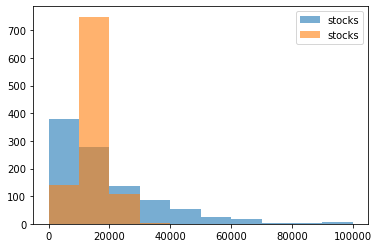

In [169]:
plt.hist(rets_stock,alpha=0.6,label='stocks',range=(0,100000))
plt.hist(rets_bond,alpha=0.6,label='stocks',range=(0,100000))
plt.legend();